In [1]:
import videopipeline as vpl
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
def add_suffix(path, suffix, new_ext='.mp4'):
    return path.replace(os.path.splitext(path)[1], f'-{suffix}{new_ext}')

ffmpeg_path = r"C:\opt\ffmpeg-2022-02-17-git-2812508086-full_build\bin\ffmpeg.exe"
video_path = r"C:\Users\johny\Desktop\Sprung_Trim.mp4"
beat_path = r"C:\Users\johny\Desktop\Sprung.txt"
output_path = add_suffix(video_path, "absprung")
final_path = add_suffix(video_path, "final", ".mp4")
img_size = (90, 200)
crop_pos = (352 - 140, 640 // 2)

In [6]:
SMOOTH = 5
DENOISE_THRESHOLD = 30
DENOISE_FILTER = 40
AOA_SMOOTH = 15
ROLL = -3
HEIGHT = 3
DISTANCE = 50

In [4]:
def read_beats(beat_file, frame_count=4361):
    with open(beat_file) as f:
        lines = list(f)
        total, lines = float(lines[0]), lines[1:]
        beats = np.array(list(map(lambda t: np.full(frame_count, float(t) / total), lines)))
        frame_times = np.linspace(0, 1, num=frame_count)
        beat_frame_set = set(np.argmin(np.abs(beats - frame_times), axis=1))
        correct_frame = np.array([f'{i in beat_frame_set}' for i in range(frame_count)])

        return correct_frame


def add_audio_to_video(*args):
    combine_cmd = f"{ffmpeg_path} -y -i {output_path} -i {video_path} -map 0:v -map 1:a -r 30 -vf \"scale='iw-mod(iw,2)':'ih-mod(ih,2)',format=yuv420p\" -movflags +faststart {final_path}"
    rtrn = os.system(combine_cmd)
    assert rtrn == 0, rtrn
    return rtrn


class AbsprungDetector(vpl.core.Function):

    def __init__(self, **kwargs):
        super().__init__(self.absprung_detection, **kwargs)

    def absprung_detection(self, position_history):
        # read positions and smooth
        pos_raw = np.array([h if h is not None else [0, 0] for h in position_history])
        pos = np.zeros((pos_raw.shape[0], 2))

        # smooth
        pos[:, 0] = np.convolve(pos_raw[:, 0], np.ones(SMOOTH), mode="same") / SMOOTH
        pos[:, 1] = np.convolve(pos_raw[:, 1], np.ones(SMOOTH), mode="same") / SMOOTH

        # get movement vector from current and last position
        vec = np.array([np.abs(pos[i] - pos[max(0, i - 1)]) for i in range(pos.shape[0])])

        # get movement magnitude from movement vector
        mag = np.linalg.norm(vec, axis=1)
        mag_s = np.convolve(mag, np.ones(SMOOTH), mode="same") / SMOOTH # smooth

        # get angle of movement vector
        aoa_noisy = np.rad2deg(np.arctan2(vec[:, 0], vec[:, 1]))
        aoa_noisy_s = np.convolve(aoa_noisy, np.ones(SMOOTH), mode="same") / SMOOTH  # smooth

        aoa_s = aoa_noisy_s * ((np.convolve(aoa_noisy_s, np.ones(DENOISE_FILTER), mode='same') / DENOISE_FILTER ) > DENOISE_THRESHOLD)  # denoise
        aoa_diff = np.array([aoa_s[i] - aoa_s[max(0, i - 1)] for i in range(aoa_s.shape[0])])  # angle of attack difference
        aoa_diff_smooth = np.convolve(aoa_diff, np.ones(AOA_SMOOTH), mode="same") / AOA_SMOOTH # smooth
        aoa_diff_flip = np.abs(np.minimum(0, aoa_diff_smooth))  # filter negative and flip
        aoa_diff_off = np.roll(aoa_diff_flip, ROLL)  # offset signal
        absprung_set = set(scipy.signal.find_peaks(aoa_diff_off, height=HEIGHT, distance=DISTANCE)[0])  # detect peaks
        absprung_frame = np.array([i in absprung_set for i in range(aoa_diff_off.shape[0])])  # write flag array

        return absprung_frame

## Absprung detection

In [5]:
raw_video = vpl.generators.ReadVideoFile(video_path)
grey = vpl.video.Rgb2Greyscale()(raw_video)
crop = vpl.video.Crop(crop_pos, img_size)(grey)
smooth1 = vpl.video.Smooth(21)(crop)
abs_diff = vpl.video.AbsDiff()(smooth1)
threshold = vpl.video.Threshold(32)(abs_diff)
dilate = vpl.video.Dilate(40)(threshold)
smooth2 = vpl.video.Smooth(11)(dilate)
canny_edge = vpl.video.CannyEdge(1, 100)(smooth2)
find_contours = vpl.video.FindContours()(canny_edge)

largest_contours = vpl.video.FilterLargestContour()(find_contours)
convex = vpl.video.ConvexHull()(largest_contours)
contour_center = vpl.video.GetContourCenter(aggregate=True, collect=True)(convex)

contour_center_drawn1 = vpl.video.DrawContourCenters()([canny_edge, contour_center])
movement_path_drawn1 = vpl.video.DrawMovementPath(color_coeff=100)([contour_center_drawn1, contour_center])

stacked = vpl.video.Stack(2, 3)([
    crop, smooth1, abs_diff,
    threshold, smooth2, contour_center_drawn1
])
writer = vpl.actions.VideoWriter(add_suffix(video_path, "dev"),
                                 30,
                                 aggregate=True,
                                 collect=False,
                                 verbose=True)(stacked)

pipeline_pos = vpl.core.Pipeline(contour_center)

In [11]:
absprunge = AbsprungDetector()(pipeline_pos)()

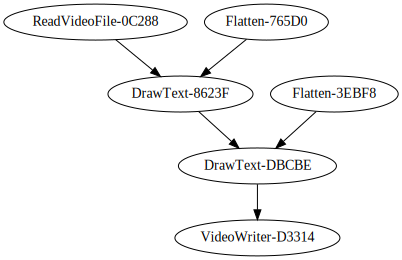

In [42]:
absprung_gen = vpl.generators.Flatten(absprunge)
beat_gen = vpl.generators.Flatten(read_beats(beat_path, 4360))

raw_video = vpl.generators.ReadVideoFile(video_path)
out_video = vpl.video.DrawText(org=(50, 50), scale=0.8, thickness=2)([raw_video, absprung_gen])
out_video = vpl.video.DrawText(org=(50, 80), scale=0.8, thickness=2)([out_video, beat_gen])

out_writer = vpl.actions.VideoWriter(output_path, 30, aggregate=True, collect=False)(out_video)

p = vpl.core.Pipeline(out_writer)
out_sound = vpl.core.Action(add_audio_to_video)(p)
p.render_model()

In [43]:
out_sound()

[]

## Detect absprung

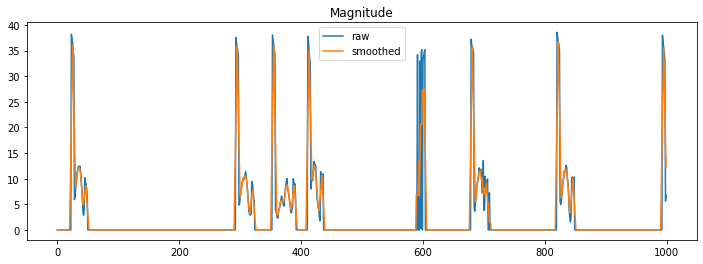

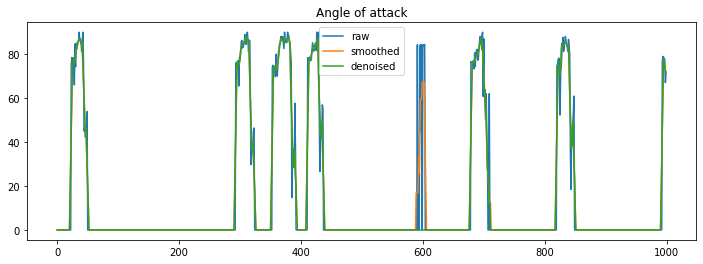

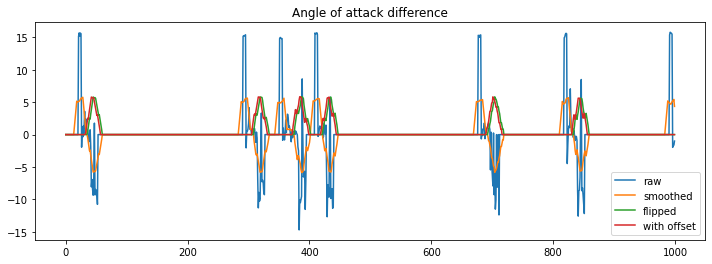

In [15]:
s = slice(1000, 2000)
plt.figure(figsize=(12,4))
plt.title("Magnitude")
plt.plot(mag[s], label="raw")
plt.plot(mag_s[s], label="smoothed")
plt.legend()

plt.figure(figsize=(12,4))
plt.title("Angle of attack")
plt.plot(aoa_noisy[s], label="raw")
plt.plot(aoa_noisy_s[s], label="smoothed")
plt.plot(aoa_s[s], label="denoised")
plt.legend()

plt.figure(figsize=(12,4))
plt.title("Angle of attack difference")
plt.plot(aoa_diff[s], label="raw")
plt.plot(aoa_diff_smooth[s], label="smoothed")
plt.plot(aoa_diff_flip[s], label="flipped")
plt.plot(aoa_diff_off[s], label="with offset")
plt.legend()